In [105]:
import os

import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split

import wandb
from tiger.data.sentence_embedding import SentenceEmbeddingsDataset
from tiger.distributions.gumbel import TemperatureScheduler
from tiger.models.semantic_id import RQVAE

In [106]:
BATCH_SIZE = 1024
LR = 0.4
NUM_EPOCHS = 2000
BETA = 0.25
CODEBOOK_SIZE = 256
LATENT_DIM = 32
TEMP = 1
MIN_TEMP = 0.1
ANNEAL_RATE = 0.00003
STEP_SIZE = 20
EMBEDDING_LOCATION = "../data/processed/2014/Beauty_sentence_embeddings.npy"
VAL_SPLIT = 0.05

In [107]:
embeddings = np.load(EMBEDDING_LOCATION)
dataset = SentenceEmbeddingsDataset(torch.from_numpy(embeddings))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, prefetch_factor=2, pin_memory=True, num_workers=4)

In [108]:
model = RQVAE()
model.load_state_dict(torch.load('../models/rqvae.pt', map_location=torch.device('cuda'), weights_only=True))
model = model.to('cuda')
model.eval()

RQVAE(
  (encoder): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=768, bias=True)
  )
  (codebooks): ModuleList(
    (0-2): 3 x Embedding(256, 32)
  )
)

In [109]:
def get_sem_ids(model, dataloader):
    model.eval()
    sem_id_list = []
    for batch in dataloader:
        batch = batch.to("cuda")
        _, sem_ids, _ = model.get_semantic_ids(batch, TEMP)
        sem_id_list.append(sem_ids)
    
    sem_ids = torch.cat(sem_id_list, dim=0)
    return sem_ids

In [110]:
import pandas as pd

sem_ids = get_sem_ids(model, dataloader)
df = pd.DataFrame(sem_ids.cpu())
display(df[0].value_counts().shape)
display(df[1].value_counts().shape)
display(df[2].value_counts().shape)

(1,)

(4,)

(6,)

In [76]:
m = RQVAE()
m = m.to('cuda')
batch = next(iter(dataloader))
batch = batch.to('cuda')
m.initialize_codebooks(batch)

In [77]:
sem_ids = get_sem_ids(m, dataloader)
df = pd.DataFrame(sem_ids.cpu())
display(df[0].value_counts().shape)
display(df[1].value_counts().shape)
display(df[2].value_counts().shape)

(256,)

(256,)

(255,)

In [94]:
import matplotlib.pyplot as plt

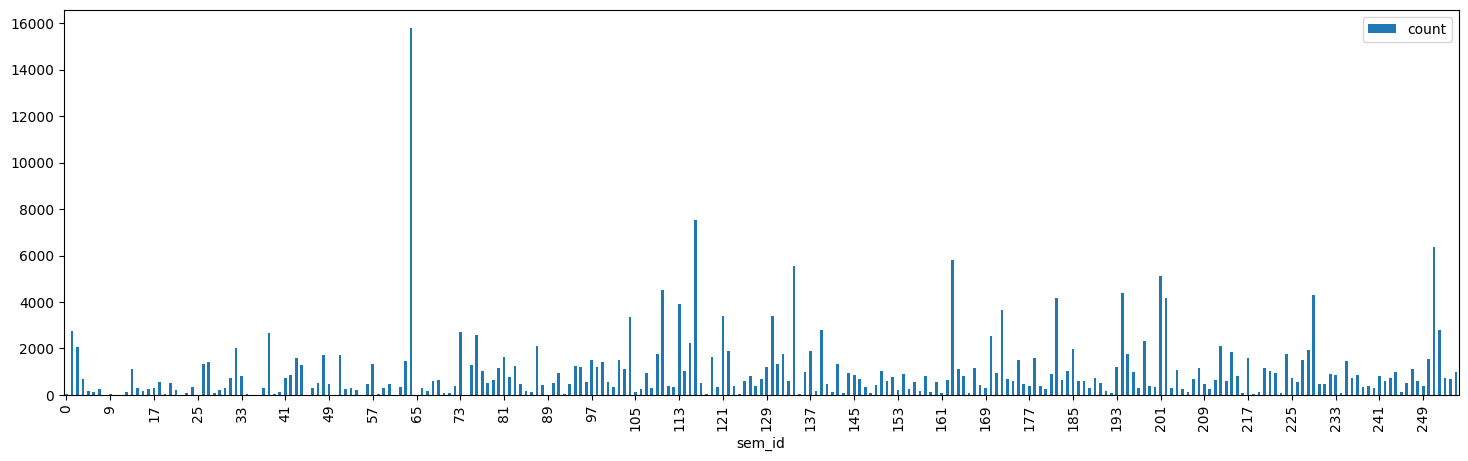

In [104]:
ax = df[2].value_counts().reset_index().rename({2: 'sem_id'}, axis=1).sort_values('sem_id').plot.bar(x='sem_id', y='count', figsize=(18,5))
ax.xaxis.set_major_locator(plt.MaxNLocator(32))

<Axes: xlabel='0'>

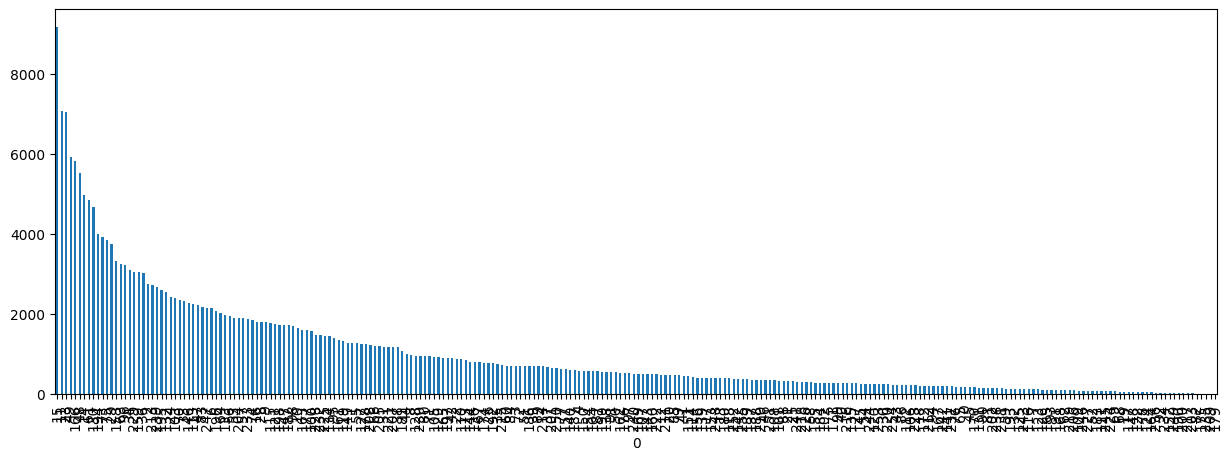

In [83]:
df[0].value_counts().plot.bar(figsize=(15,5))

(11,)